# Cash-Karp Method

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


## Define set of ODEs to integrate

In [2]:
def dfdx(x,f):
    
    
    y = f[0]
    
    #dy/dx = z      
    z = f[1]
    
    dydx = np.zeros_like(f)
    dydx[0] = z
    dydx[1] = -1*y
    
    return dydx

## Define the core of the Cash-Karp method

In [3]:
def ck_core_mv(x_i, y_i, nv, h, f):
    
    #making arrays to hold my constants
    ci = np.array([0,0, 1./5., 3./10., 3./5., 1, 7./8.])
    
    #aij as a matrix
    aji = np.array([[0,0,0,0,0,0,0],
                    [0,0, 1./5., 3./40., 3./10., -11./54., 1631./55296.],
                   [0,0,0, 9./40., -9./10., 5./2., 175./512.],
                   [0,0,0,0, 6./5., -70./27., 575./13824.],
                   [0,0,0,0,0, 35./27., 44275./110592.],
                   [0,0,0,0,0,0,253./4096.]])

    aij = aji.transpose()
    
    bi = np.array([0, 37./378.,0,250./621.,125./594.,0,512./1771.])
    bistr = np.array([0,2825/27648.,0,18575./48384.,13525./55296.,277./14336.,1./4.])

    #define k array
    ni = 7
    ki = np.zeros((ni,nv))
    
    #compute ki
    for i in range(1,ni):
        # xn+1
        xn = x_i + ci[i]*h
        
        #temp y
        yn = y_i.copy()
        for j in range(1,i):
            yn += aij[i,j]*ki[j,:]
            
        ki[i,:] = h*f(xn,yn)
    ynp1 = y_i.copy()
    ynp1s= y_i.copy()
    
    for i in range(1,ni):
        ynp1 += bi[i]*ki[i,:]
        ynp1s += bistr[i]*ki[i,:]
        
    #get error
    Delta = np.fabs(ynp1-ynp1s)
    
    return ynp1, Delta
    
    

## Define the adaptive step driver

In [4]:
def ck_mv_ad(dfdx,x_i,y_i,nv,h, tol):
    
    #how big of step, find that the error is not too large
    SAFETY = 0.9
    H_NEW_FAC = 2.0 #if step is too small, fix for tol and ___ to match? max factor in which step will change between steps
    
    imax = 1000
    
    i = 0
    
    #create an error array, to keep track of errors
    Delta = np.full(nv, 2*tol) #initialize every element 
    
    h_step = h
    
    #adjust step to get more accurate answer
    #__.max menas max in array (method)
    while(Delta.max()/tol > 1.0):
        
        #value at end of step
        y_ipo, Delta = ck_core_mv(x_i,y_i,nv,h_step,dfdx)
        
        
        if(Delta.max()/tol > 1.0):
            
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check integration
        if(i>=imax):
            print("Too many iterations in ck_mv_ad")
            raise StopIteration("Ending after i =", i)
            
        #iterate
        i += 1
        
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step * H_NEW_FAC)
    
    return y_ipo, h_new, h_step                      
                

## Define a wrapper for CK, set up the integral

In [5]:
def ck_mv(dfdx,a,b,y_a,tol,v=False):
    
    #y_a are the boundary conditions at a
    # a and b are lower and upper boundaries
    
    #starting steps
    xi = a
    yi = y_a.copy()
    
    h = 1.0e-4 * (b-a)
    
    #max iterations
    imax = 1000
    
    i = 0
    
    #variables are the length 
    nv = len(y_a)
    
    #set initial conditions
    x = np.full(1,a)
    y = np.full( (1, nv), y_a)
    #makes an array, adding elements to the array
    #1000 elements at 5 = (1000, 5)
    
    #loop until we reach b
    flag = True
    while(flag):
        
        y_ipo, h_new, h_step = ck_mv_ad(dfdx,xi,yi,nv,h,tol)
         
        #new step
        h = h_new
        
        #prevent an overshoot
        if(xi + h_step>b):
            
            #step will end at b
            h = b-xi
            
            #recompute
            y_ipo, h_new, h_step, = ck_mv_ad(dfdx,xi,yi,nv,h,tol)
            
            flag = False
            
            
        #update values
        xi += h_step
        yi = y_ipo.copy()
        
        #add step
        x = np.append(x,xi)
        y_ipo = np.zeros((len(x),nv))
        y_ipo[0:len(x)-1,:] = y[:]
        y_ipo[-1,:] = yi[:]
        del y
        y = y_ipo
        
        #prevent too many iterations
        if(i>=imax):
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ",i)
            
        #iterate
        i += 1
        
        #output some information
        if(v):
            s = "i = %3d/tx = %9.8f\ty = %9.8f\th = %9.8f\tb = %9.8f" % (i,xi,yi[0],h_step,b)
            print(s)
            
        if(xi==b):
            flag = False
            
    return x,y 
        

## Peform the Integration

i =   1/tx = 0.00062832	y = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2/tx = 0.00188496	y = 0.00188495	h = 0.00125664	b = 6.28318531
i =   3/tx = 0.00439823	y = 0.00439822	h = 0.00251327	b = 6.28318531
i =   4/tx = 0.00942478	y = 0.00942464	h = 0.00502655	b = 6.28318531
i =   5/tx = 0.01947787	y = 0.01947664	h = 0.01005310	b = 6.28318531
i =   6/tx = 0.03958407	y = 0.03957373	h = 0.02010619	b = 6.28318531
i =   7/tx = 0.07979645	y = 0.07971180	h = 0.04021239	b = 6.28318531
i =   8/tx = 0.16022123	y = 0.15953660	h = 0.08042477	b = 6.28318531
i =   9/tx = 0.32107077	y = 0.31558279	h = 0.16084954	b = 6.28318531
i =  10/tx = 0.64276986	y = 0.59941495	h = 0.32169909	b = 6.28318531
i =  11/tx = 0.93739384	y = 0.80601851	h = 0.29462398	b = 6.28318531
i =  12/tx = 1.20675386	y = 0.93446544	h = 0.26936002	b = 6.28318531
i =  13/tx = 1.49426997	y = 0.99707369	h = 0.28751611	b = 6.28318531
i =  14/tx = 1.76344767	y = 0.98150050	h = 0.26917769	b = 6.28318531
i =  15/tx = 2.03076151	y = 0.8960

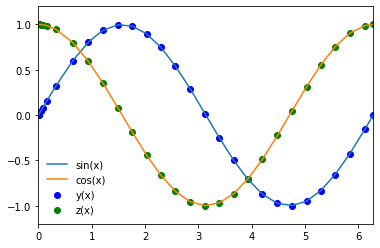

In [6]:
a = 0.0
b = 2.0*np.pi
y0 = np.zeros(2)
y0[0] = 0.0
y0[1] = 1.0
nv = 2

tolerance = 1.0e-6
x,y = ck_mv(dfdx,a,b,y0,tolerance,v = True)

plt.scatter(x,y[:,0], color= 'blue', label = 'y(x)')
plt.scatter(x,y[:,1], color= 'green', label = 'z(x)')
plt.plot(x,np.sin(x), label='sin(x)')
plt.plot(x,np.cos(x), label='cos(x)')
plt.xlim([0,2*np.pi])
plt.ylim([-1.2,1.2])
plt.legend(frameon=False)


## Plot the error

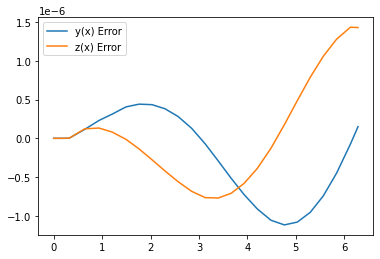

In [7]:
plt.plot(x,y[:,0]-np.sin(x), label="y(x) Error")
plt.plot(x,y[:,1]-np.cos(x), label="z(x) Error")
plt.legend()